# King County Housing Predictions
### Using Linear Regression to predict housing prices in Seattle

## Table of Contents
### 1) Geolocation Data
### 2) Time Series Data
### 3) Feature Interactions
### 4) Constructing my model piecewise
### 5) Testing the model
### 6) Lasso regression 


In [113]:
# import src 

# sklearn packages
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler ,minmax_scale, PolynomialFeatures, StandardScaler

# Statsmodels
from statsmodels.formula.api import ols

# Geolocation
import pandas as pd
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

# utility libraries 
from scipy import stats
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geohash2
import itertools

import warnings 

# filter warnings
warnings.filterwarnings("ignore")

# magic inline
%matplotlib inline

# Exploratory Data Analysis

## How does the houses location effect price?
### Dealing with Geolocation data

In [2]:
# import raw data 
geo = pd.read_csv('../cleanedData/geoOverlap.csv')
X = pd.read_csv('../cleanedData/X.imputed.csv', index_col=0) # imputed median for bed and bath where they == 0
y = pd.read_csv('../raw/y.csv', header = None) # training y
y.columns = ['price']
holdout = pd.read_csv('../raw/kc_holdout_data.csv') # holdout
training_data = pd.concat([X, y], axis=1)

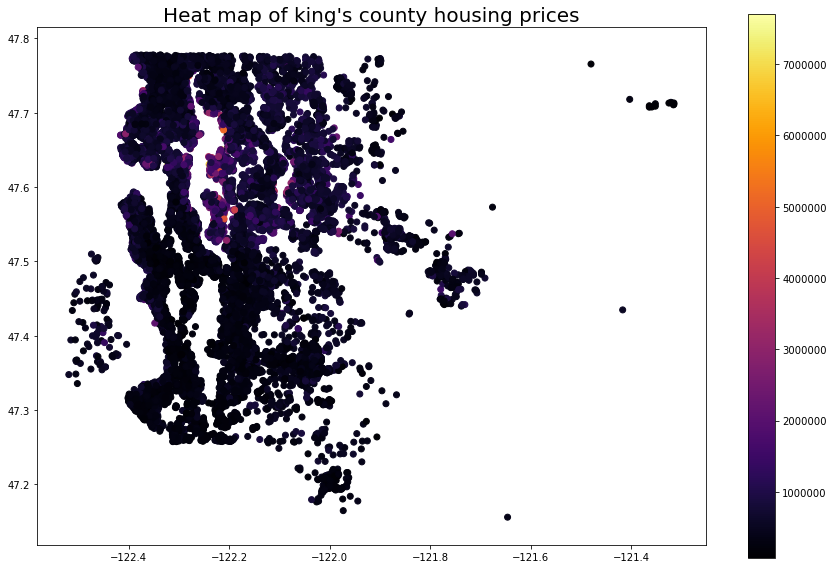

In [49]:
# Let's get rid of the everything but the price, longitude and latitude for now
geometry = [Point(xy) for xy in zip(training_data["long"], training_data["lat"])]
geometry[:5]

# Horizontal component of 3D system. 
# Used by the GPS satellite navigation 
# system and for NATO military geodetic surveying.
crs = {'init': 'epsg:4326'}
geo_df = gpd.GeoDataFrame(training_data,
                         crs=crs,
                         geometry=geometry)


fig,ax = plt.subplots(figsize = (15,10))
# ax.set_ylim(5900000, 6300000)
# map_df.plot(ax=ax, alpha=0.4, color="blue")
geo_df.plot(ax=ax,
            column ='price',
            cmap = 'inferno', 
            legend=True ,
           )
plt.title("Heat map of king's county housing prices", size = (20));



### If I had more time I would create a folium map with city limits but the story of the data is quite clear.

There is a tight region where the housing prices are particulalry high. They surround a body of water so anything near a coast should have higher prices. In our data set, houses with an ocean view have a significantly higher median price.

I would also like to look into distance from parks and utilities like schools in my data set. Arcpy is a package that I have been looking into to implement this. 

In [4]:
# null hypothesis is that there is no difference between the means of waterfront and non waterfront properties
# alternative hypothesis is that there is a significant difference between the means
delta=training_data[training_data.waterfront == 1].price.median() - training_data[training_data.waterfront == 0].price.median()

stats.levene(training_data[training_data.waterfront == 1].price, 
              training_data[training_data.waterfront == 0].price) 
stat= stats.ttest_ind(training_data[training_data.waterfront == 1].price,
                training_data[training_data.waterfront == 0].price, 
                equal_var=False)



print(f'The median difference in price between homes with a coastal view and those with out is {delta} \
which is statistically signeficant with a p_value of {stat[1]}')

The median difference in price between homes with a coastal view and those with out is 955000.0 which is statistically signeficant with a p_value of 6.940441256090536e-23


### Zipcodes as a linear regression feature

Since I know that some regions have a much higher average price than others, I can test whether or not price and zipcodes are correlated. Zipcodes are ordinal in that close regions share prefix's but I hypothesise that treating zipcodes as categorical will yeild better results than if we just had it as a column.

we can test this hypothesis by running two regressor models and comparing the R squared for each

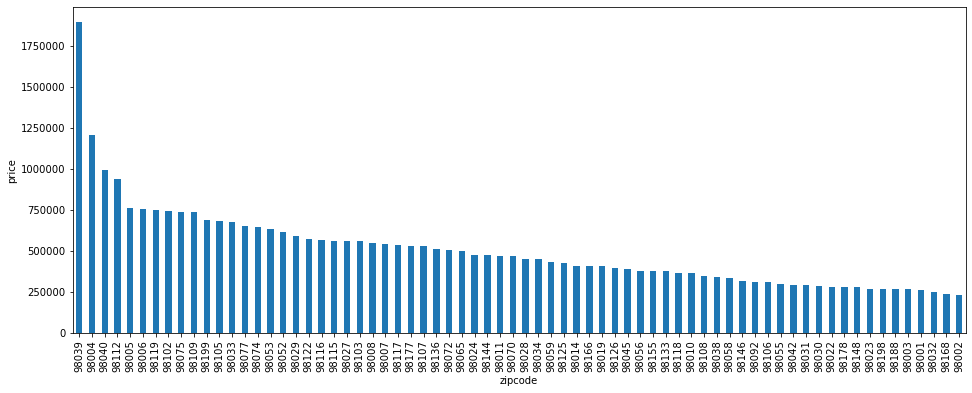

In [5]:
# median housing price per zipcode
zipcode_groupby = training_data.groupby(['zipcode']).price.median().sort_values(ascending=False)
plt.figure(figsize=(16,6))
plt.ylabel('price')
zipcode_groupby.plot(kind='bar');

In [6]:
zipcode_dummies = pd.get_dummies(X.zipcode).iloc[:,:-1] # removing 1 zipcode as the reference zipcode
zipcodes = X['zipcode']

lr1 = LinearRegression().fit(pd.DataFrame(zipcodes), y)
lr2 = LinearRegression().fit(zipcode_dummies, y)
lr1_yHat = lr1.predict(pd.DataFrame(zipcodes))
lr2_yHat = lr2.predict(zipcode_dummies)

RMSE1 = mean_squared_error(y,lr1_yHat)**0.5
RMSE2 = mean_squared_error(y, lr2_yHat)**0.5

print(f"zipcodes as ordinals RMSE = {RMSE1} \n\
zipcodes as dummies gave an RMSE of {RMSE2}")

zipcodes as ordinals RMSE = 372860.51696325414 
zipcodes as dummies gave an RMSE of 288813.04959021363


We will use the zipcodes as dummy variables moving forward. 

### Latitude and Longitudes as features aka Geohashing

The only things that actually correlate with latitiude and longitude are the average daylight hours and temperature over the year. Since I want to know how location effects price, I will instead use a package called geohash2. 

Geohash2 uses non-euclidean, haversine geodesic geometry to "bucket" a region into zones based on a space filling z-curve (https://en.m.wikipedia.org/wiki/Z-order_curve) and then assigns a hash value to that zone. Neighbouring zones share prefixes. But we are more interested in which zones have the strongest correlation on price. Therefore, similar to zipcodes, I will bucket the geohashes as they are strickly categorical

From the graph below, we can see that there are now 4 regions that are visually more pricey than the others. We have increased the granualarity of our observations. 

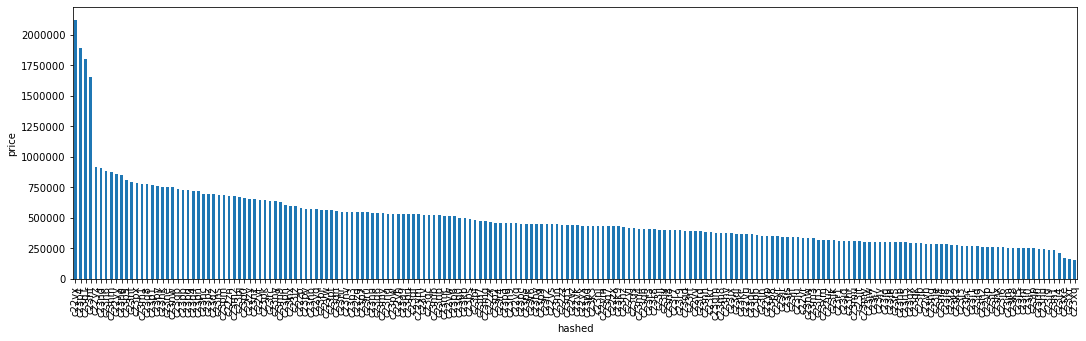

In [7]:
# create a location df with just lat and long
def geo_hash(lat, long):
    return geohash2.encode(lat, long, 5)

location = training_data[['lat', 'long']]
# create a hashed location column in the location data base
location['hashed_location'] =location.apply(lambda x: geo_hash(x['lat'], x['long']), axis=1)

# Add the hashed_location to the training data
training_data['hashed'] = location.hashed_location

# plot the hashed data with price
plt.figure(figsize=(18,5))

plt.ylabel('price')
training_data.groupby(['hashed']).price.median().sort_values(ascending=False).plot(kind='bar');

### We have split the high price location into more regions and smoothed out our curve.
I will make dummy columns for the this data and the holdout data, see the supplementary notebooks `trainGeohashing.ipynb` and  `geohashingClustering.ipynb`.

Through visual analysis, it appears that 1 (98093) zipcode and 4 of the geohashes have signeficantly large mean house prices. When we come to model building and feature selection we will test the importance of each geo hash more rigorously. Let's check that none of the geohashed regions have less than 30 observations

In [8]:
training_data.groupby(['hashed']).price.count().sort_values()[:10]

hashed
c23k3    1
c23k9    1
c23qx    1
c23r5    1
c23r7    1
c23q1    1
c23rc    1
c22vx    1
c23mc    1
c23xm    1
Name: price, dtype: int64

I do not want to drop these columns yet, but when we start working on feature selection, we will have to make a decision about these outliers. In addition, I know that not all geohashes are shared between groups. Let's check the shared geohashes. It looks like we have narrowed down the number of geohashes shared between the sets to just 5. Less of a big deal to drop these. Let's check to see what

In [9]:
shared_geo = pd.read_csv('../cleanedData/geoOverlap.csv', index_col=0)
boolean = shared_geo != 0
only_one = boolean.sum().sort_values()[:5].index
interest = shared_geo[only_one]

# get the indexs that I need to check on the house locations
interest_index = [interest[interest[column] ==1].index[0] for column in interest.columns]
X.iloc[interest_index]

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
13592,323079101,20150123T000000,4,3.50,6370,205603,2.0,0,0,3,12,6370,0,2008,0,98027,47.5016,-121.905,1490,33580
17081,821079102,20141017T000000,4,3.50,3720,213073,1.0,0,2,3,10,3720,0,2007,0,98010,47.3216,-121.940,2190,59241
17048,522079068,20150506T000000,3,2.50,2150,161607,2.0,0,0,3,7,1330,820,1995,0,98038,47.4178,-121.937,2400,207781
13386,774101755,20150417T000000,3,1.75,1790,66250,1.5,0,0,3,7,1790,0,2003,0,98014,47.7179,-121.403,1440,59346
3262,820079043,20140819T000000,3,1.75,1580,507038,1.0,0,2,4,7,1580,0,1985,0,98022,47.2303,-121.936,2040,210394


Upon visual inspection of the houses in google maps, I can confirm that they are all normal, nice houses and I don't see why I should remove them outright from the data frame. However, when it comes to feature selection and model development I will make my decision.

## Does the time of the year effect the price of house?
### Dealing with time series data

I am not fully equiped to deal with time series data yet. However, I will do some binning and dummy creations as best as I can. In addition, I suspect there is a polynomial relationship between week of the year and price. 

Let's visually inspect months

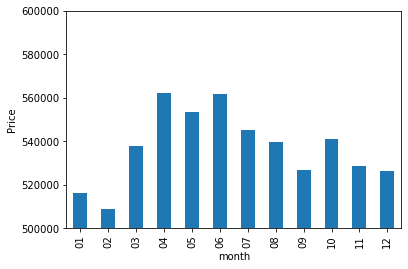

In [10]:
# Create a datetime object from the date column
datetime = pd.to_datetime(X.date)
# convert the date to months
month = datetime.dt.strftime("%m")
# append the months column to the dataframe
X['month'] = month
# Plot the month data against month
month_df = pd.concat([X['month'], y], axis=1)
month_df.groupby(['month']).price.mean().plot(kind='bar')
plt.ylim(500000,600000)
plt.ylabel('Price');

#### Visual inspection suggests  month 4-6 behave differently to months 3,7,8,10 and different still to 1,2,11,12

I will perform ttests between the three "seasons" to confirm a difference

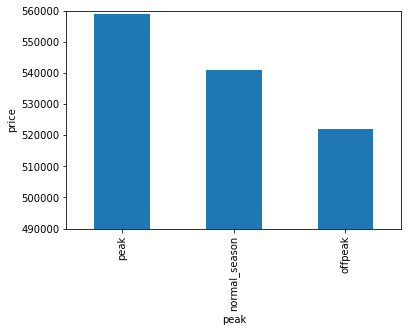

In [11]:
def peak_season(month):
    if month in [4,5,6]:
        return 'peak'
    elif month in [1,2,9,11,12]:
        return 'offpeak'
    else:
        return 'normal_season'

test = pd.concat([X, y], axis=1)
test.month = test.month.astype(int)

test['peak'] = test.month.apply(peak_season)

test.groupby('peak').price.mean().sort_values(ascending=False).plot(kind='bar')
plt.ylabel("price")
plt.ylim(490000, 560000);

In [12]:
### Perform two tailed t tests between the groups

peak = test[test.peak == 'peak']
offpeak = test[test.peak == 'offpeak']
normal = test[test.peak == 'normal_season']

# peak vs off peak ttest 
print("peak vs off peak:")
print(f"peak vs off peak mean difference: {peak.price.mean() - offpeak.price.mean()}")
stats.levene(peak.price, offpeak.price) # Levenes Rejected
print(f"peak vs off peak p value: {stats.ttest_ind(peak.price, offpeak.price, equal_var=False)[1]}")
print("*"*60)
print("peak vs regular season:")
# peak vs regular season
print(f"peak vs regular season mean difference: {peak.price.mean()-normal.price.mean()}")
stats.levene(peak.price, normal.price) # Levens Failed to reject
print(f"peak vs regular season p value: {stats.ttest_ind(peak.price, normal.price)[1]}") # significant 
print("*"*60)
print("normal vs offpeak:")
# normal season vs offpeak
print(f"normal season vs offpeak mean difference: {normal.price.mean() -  offpeak.price.mean()}")
stats.levene(normal.price, offpeak.price) # Rejected
print(f"normal season vs offpeak p value: {stats.ttest_ind(normal.price, offpeak.price, equal_var=False)[1]}")

peak vs off peak:
peak vs off peak mean difference: 36720.238000085636
peak vs off peak p value: 2.334085061315023e-07
************************************************************
peak vs regular season:
peak vs regular season mean difference: 17824.835047457367
peak vs regular season p value: 0.011016854999620442
************************************************************
normal vs offpeak:
normal season vs offpeak mean difference: 18895.40295262827
normal season vs offpeak p value: 0.005178077743120801


### Test the polynomial nature of week on price

The graph of weeks vs price apears to follow a sin wave. I will two things, I will first just fit a polynomial, then I will fit a sin wave and see which performs better

In [41]:
week = datetime.dt.strftime("%W")
X['week'] = week.astype(int)
X['week^2'] = X['week']**2
X['week^3'] = X['week']**3
X['week^4'] = X['week']**4
X['week^5'] = X['week']**5
X['week^6'] = X['week']**6
X['week^7'] = X['week']**7
week_df = X[['week','week^2','week^3', 'week^4', 'week^5', 'week^6', 'week^7']]

dummy_predictor = DummyRegressor().fit(X,y)
dumb_hat = dummy_predictor.predict(X)
RMSE_dumb = mean_squared_error(y, dumb_hat)**0.5


lr = LinearRegression().fit(week_df, y)
y_hat = lr.predict(week_df)
RMSE = mean_squared_error(y , y_hat)**0.5
print(f"The RMSE for the polynomial weekly function is {RMSE} and dummy was {RMSE_dumb}")

The RMSE for the polynomial weekly function is 373018.22338589095 and dummy was 373308.18278696557


A polynomial fit for time did not work in this instance. But what about month? Month doesn't show a strong relationship with price either. 

In [72]:
month_df.drop(columns=['price'], inplace=True)
month_df['month'] = month_df.month.astype(int)
month_df['month^2'] = month_df['month']**2
month_df['month^3'] = month_df['month']**3
month_df['month^4'] = month_df['month']**4

lr = LinearRegression().fit(month_df, y)
y_hat = lr.predict(month_df)
RMSE = mean_squared_error(y , y_hat)**0.5
print(f"The RMSE for the polynomial weekly function is {RMSE} and dummy was {RMSE_dumb}")

The RMSE for the polynomial weekly function is 373073.8801748056 and dummy was 373308.18278696557


#### The last hypothesis to test is month as a categorical data

Though they did not have an effect on the RMSE, I will try adding dummy months as an interaction in the model building phase

In [78]:
month_dummies = pd.get_dummies(month_df.month).iloc[:,:-1] # remove december as reference column

lr = LinearRegression().fit(month_dummies , y)
y_hat = lr.predict(month_dummies)
RMSE = mean_squared_error(y , y_hat)**0.5
print(f"The RMSE for the monthly dummies is {RMSE} and dummy was {RMSE_dumb}")

The RMSE for the monthly dummies is 372987.19020239706 and dummy was 373308.18278696557


In [79]:
season_dummies = pd.get_dummies(test.peak)#.iloc[:,:-1] # remvoing one season as refrence
lr = LinearRegression().fit(season_dummies , y)
y_hat = lr.predict(season_dummies)
RMSE = mean_squared_error(y , y_hat)**0.5
print(f"The RMSE for the monthly dummies is {RMSE} and dummy was {RMSE_dumb}")

The RMSE for the monthly dummies is 373022.933888759 and dummy was 373308.18278696557


## Is there a combination between features that increases the cost of a home?

### Find all the interactions between features

First, I'll check for colinearity and then I will check for interactions between all features. I did my exploratory data analysis in `./eda/` and I will be referencing key findings as we progress through this notebook.


In [ ]:
X = X.drop(columns = ['id', 'date'])
X.head()

In [80]:
X = X.drop(columns = ['id', 'date'])
X.head()

# Split data into types
discrete_features = [
    'bedrooms',
    'bathrooms',
    'floors',
    'yr_built',
]

ordinal_features = [
    'condition',
    'grade',
#     'zipcode',
    'view',   
]

continuous_features = [
    'sqft_living',
    'sqft_lot',
    'sqft_above',
#     'lat', # Removed as I have already handled this 
#     'long', # Removed as I have already handled this 
    'sqft_living15',
    'sqft_lot15',
    'yr_renovated'
]

dummy = [
    'waterfront',
    'sqft_basement', # Since most are none at all, I will ultimately be treating this column like a dummy in my model
]

### Discrete Variables 

Discrete variables are countable and ordered. In our data set, I am interested in the combinations of categorical, discrete and continuous variables and the potential interaction between them. During the model building phase I intend on testing the interaction between all of the data types, but it is good to visualise them here.

The data is typical of discrete data. The exception is year built. Indeed, I will change the year built column to age column by subtracting the year built from 2015. But everything else looks ok. I don't think any columns qualify for non-linear transformations

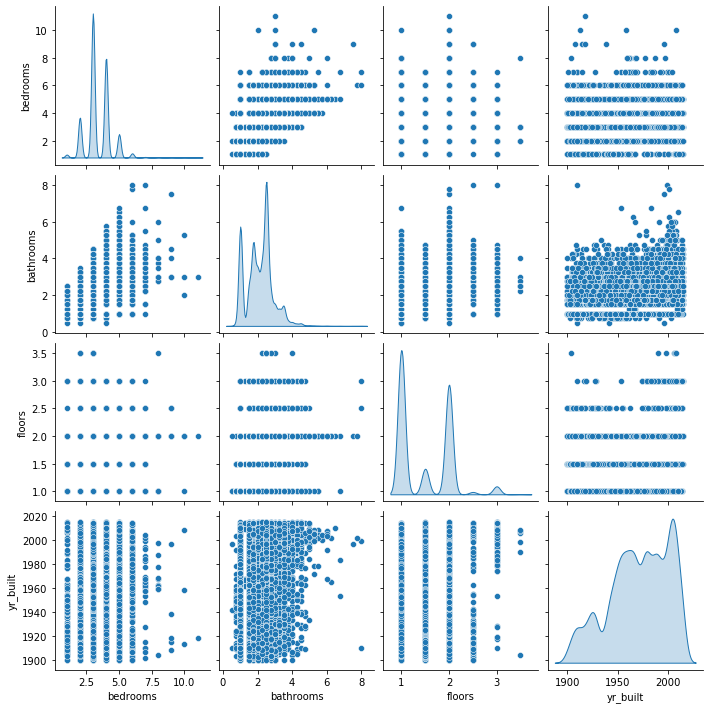

In [81]:
# Discrete Variables
sns.pairplot(X[discrete_features] , diag_kind='kde');

## Ordinal variables

Ordinal variables are categorical but they have an order to them. Grade 1 is worse than grade 13 for instance and each of these features are of this kind.

most of the data looks ok but view is heavily skewed. There may be opportunity to do a non-linear transformation

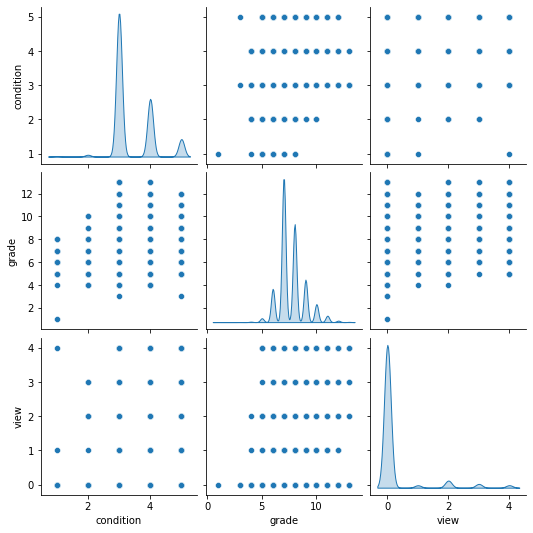

In [83]:
sns.pairplot(X[ordinal_features] , diag_kind='kde');

## A lot of colinearity between features here.

I do not think that we care about colinearity when we are working with a predictive model. From this article:https://www.kdnuggets.com/2019/08/predictor-collinearity.html I gleaned that provided you have several thousand observations, the influence of colinearity becomes vastly less important for a predictive model. I don't want to drop any of the columns. 

However, some of the columns should be and will be transformed. In particular, any feature that looks at square foot seems to be heavily skewed. 

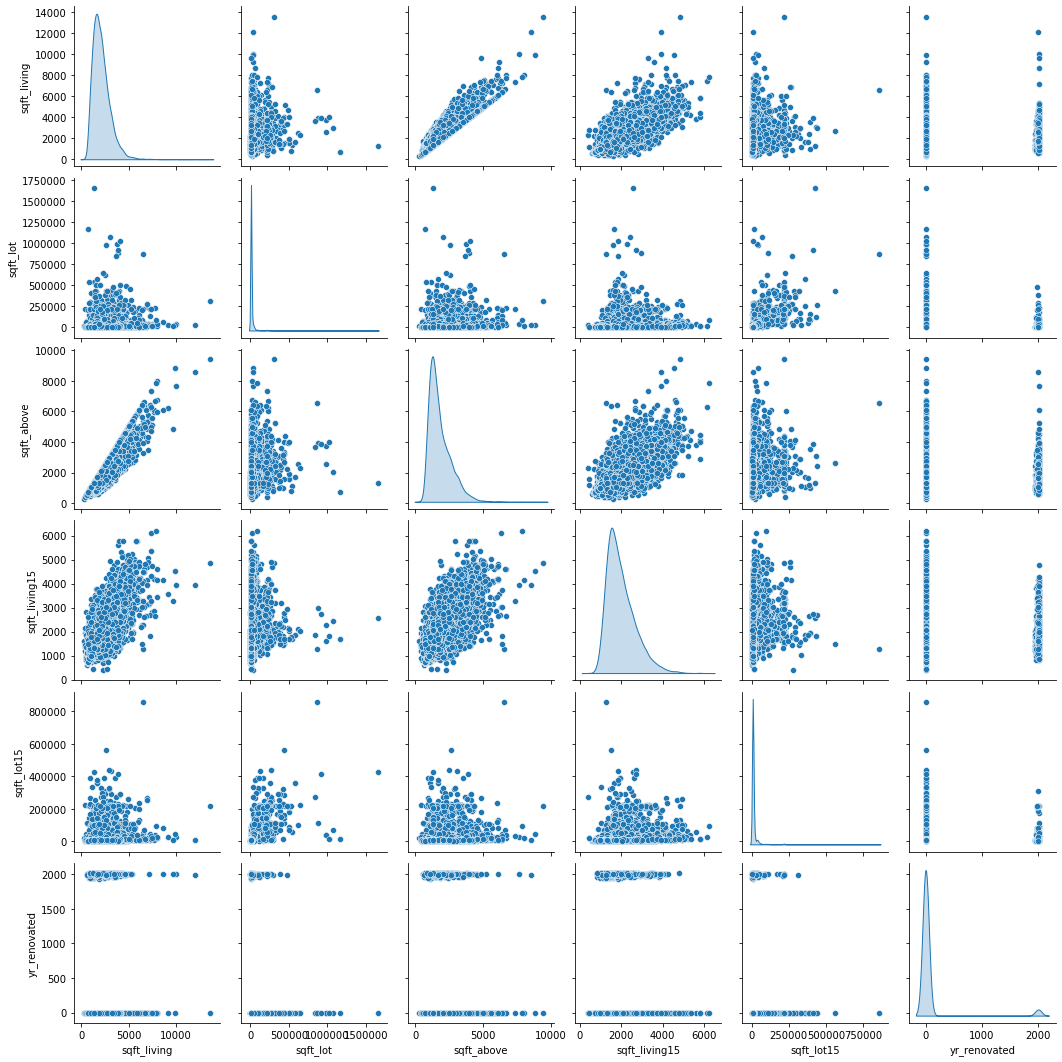

In [84]:
sns.pairplot(X[continuous_features] , diag_kind='kde');

## Understanding My Features

### Domain Knowledge 

Currently, my girlfriend and I are in the market to buy a house. There are so many things to consider the value of a home. To name a few that I am unable to check:
1) Ratio between houses sold and houses listed ie supply demand

2) distance between the house and a high quality school/highschool

3) Distance to public transportation

4) Distance to parks/water

However, when thinking about say a 2 bedroom. What is really important is that there is two baths. The ratio or interaction between bed and bath is critical in bed price. let's plot that interaction.

As we can see, there is definitely a linear interaction between bed and bath. Since I have a lot of features, I will not be testing them all individually. Indeed, analysing every interaction individually, will not always work considering the mutlidimensional structure of the data.

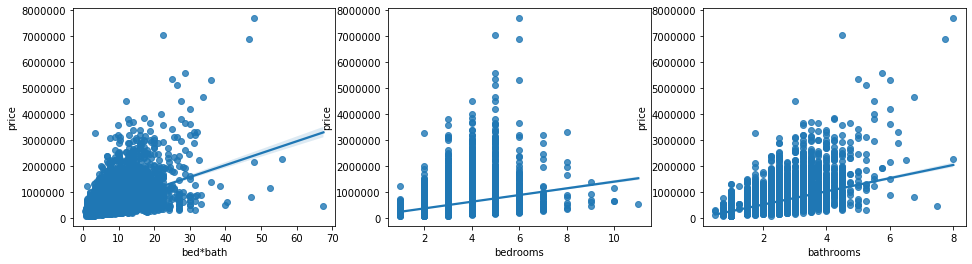

In [95]:
# Plotting beds and bath interaction 
fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

X['bed*bath']= X.bathrooms * X.bedrooms

sns.regplot(x=X['bed*bath'], y=y, ax=ax1)
sns.regplot(x=X['bedrooms'], y=y, ax=ax2)
sns.regplot(x=X['bathrooms'], y=y, ax=ax3);

### Let's stay with bathrooms briefly and look at the relationship between bath and price

Text(0.5, 1, 'Housing price vs Bathrooms')

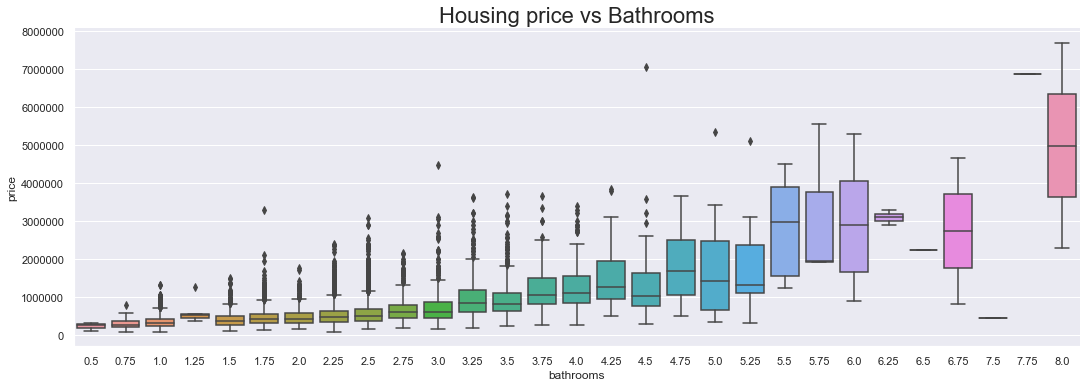

In [122]:
bathrooms= pd.concat([X['bathrooms'], y], axis=1)
sns.catplot(x='bathrooms',
            y='price', 
            data=bathrooms, 
            kind='box',
            height = 5,
            aspect = 3,
            ax=ax);
plt.title("Housing price vs Bathrooms", size = (22));

In [ ]:
A very strong, potentially exponential relationship between housing a 

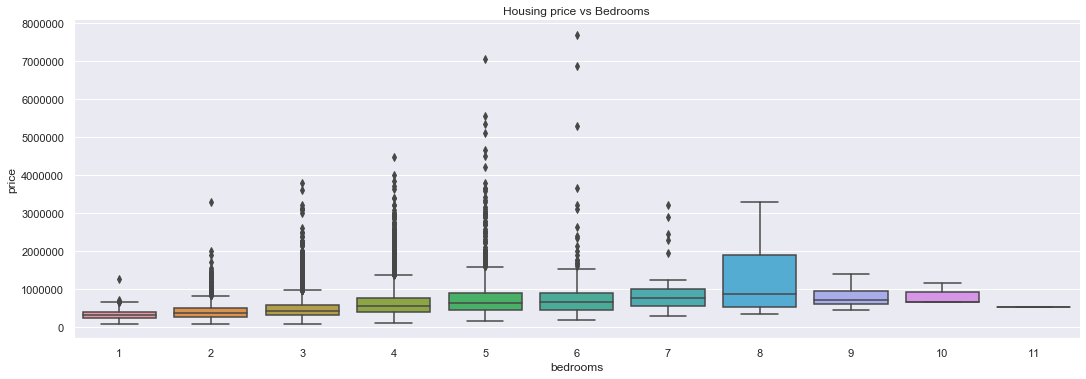

In [123]:
bedrooms = pd.concat([X['bedrooms'], y], axis=1)
sns.catplot(x='bedrooms',
            y='price', 
            data=bedrooms, 
            kind='box',
            height = 5,
            aspect = 3,
            ax=ax)
plt.title("Housing price vs Bedrooms", size=(22));

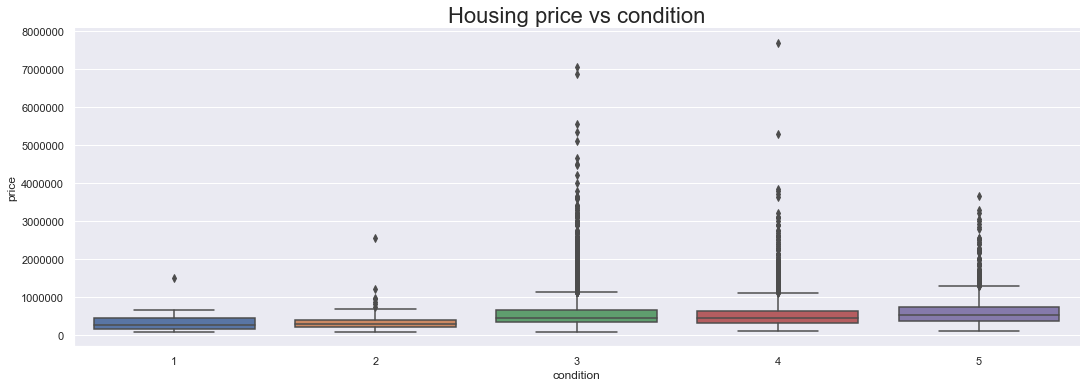

In [145]:
condition = pd.concat([X['condition'], y], axis=1)
sns.catplot(x='condition',
            y='price', 
            data=condition, 
            kind='box',
            height = 5,
            aspect = 3,
            ax=ax)
plt.title("Housing price vs condition", size=(22));

## Run an Anova

Another strong candidate for a polynomial relationship. 

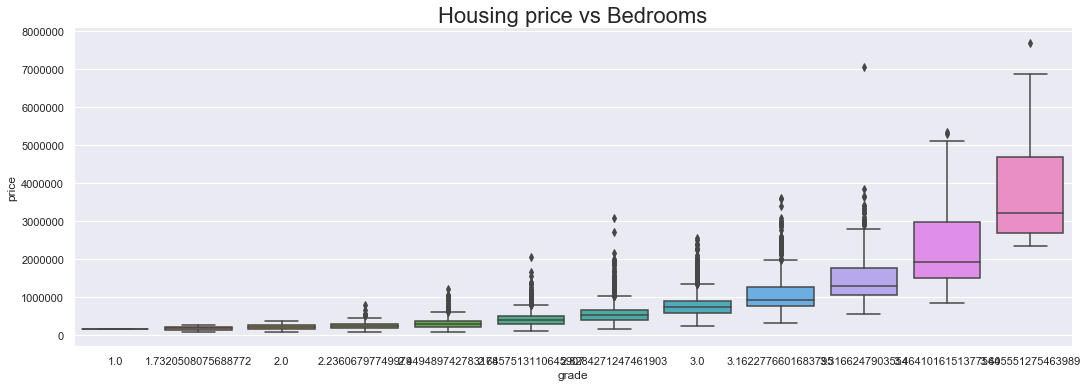

In [142]:
grade = pd.concat([np.sqrt(X['grade']), y], axis=1)
sns.catplot(x='grade',
            y='price', 
            data=grade, 
            kind='box',
            height = 5,
            aspect = 3,
            ax=ax)
plt.title("Housing price vs Grade", size=(22));

Polynomial relationship

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


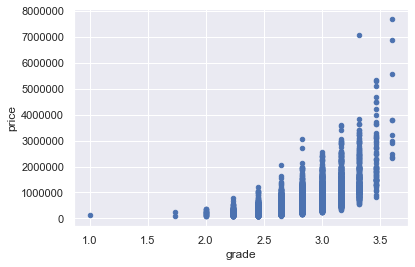

In [143]:
grade.plot(x='grade', y='price',kind='scatter')

### imported my imputed X and y

imputation was based on research I conducted with a classmate using zillow. All of the bedbaths that had 0 were not actually 0. The mean bed bath of the 12 houses we looked at was not signeficantly different to the population mean so we imputed those values. 

In addition, there was 1 house with 33 bedrooms, after looking the house up I concluded that it actually has 3 bedrooms so i changed it's value

In [14]:
df_initial = pd.read_csv('../cleanedData/X.imputed.csv', index_col=0)
y = pd.read_csv('../raw/y.csv', header=None)
y.columns = ['price']
season_dummies = pd.read_csv('../cleanedData/seasonDummies.csv')

In [15]:
# concat the season dummies into the data frame
df = pd.concat([df_initial, season_dummies], axis=1)# 

In [16]:
df.shape[0]**0.5

131.49144458861193

# Dropping columns


In [184]:
to_drop = [
    'id', # arbitrary/random. Removed. 
    'date', # Adding polynomial week into the model, the rest handled by seasonality
    'zipcode', # handled in dummy columbs
    'lat', # handled using geohashing
    'long' # handled using geohashing

]

In [185]:
df.drop(columns=to_drop, inplace=True)

In [186]:
df.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,offpeak,peak
0,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,2390,7700,0,0
1,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,2370,6283,0,0
2,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,3710,9685,0,0
3,3,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,0,4050,14226,0,0
4,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,2250,4050,0,0


### change yr_built to house age and yr_renovated to age before poly variable creation

In [187]:
df.yr_built = df.yr_built.apply(lambda x: 2015-x)
df.yr_renovated = df.yr_renovated.apply(lambda x: 2015-x)

# The Model Diverges from Model two here into the polynomial model

In [188]:
# instantiate my polynomial object
poly = PolynomialFeatures(degree=2, include_bias=False)

In [189]:
# Create the interaction columns
poly_data = poly.fit_transform(df)
# Get the column names
poly_columns = poly.get_feature_names(df.columns)
# Create the new data frame
df_poly = pd.DataFrame(poly_data, columns=poly_columns)
# Look at the new data frame
df_poly.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,sqft_living15^2,sqft_living15 sqft_lot15,sqft_living15 offpeak,sqft_living15 peak,sqft_lot15^2,sqft_lot15 offpeak,sqft_lot15 peak,offpeak^2,offpeak peak,peak^2
0,4.0,2.25,2070.0,8893.0,2.0,0.0,0.0,4.0,8.0,2070.0,...,5712100.0,18403000.0,0.0,0.0,59290000.0,0.0,0.0,0.0,0.0,0.0
1,5.0,3.00,2900.0,6730.0,1.0,0.0,0.0,5.0,8.0,1830.0,...,5616900.0,14890710.0,0.0,0.0,39476089.0,0.0,0.0,0.0,0.0,0.0
2,4.0,2.50,3770.0,10893.0,2.0,0.0,2.0,3.0,11.0,3770.0,...,13764100.0,35931350.0,0.0,0.0,93799225.0,0.0,0.0,0.0,0.0,0.0
3,3.0,3.50,4560.0,14608.0,2.0,0.0,2.0,3.0,12.0,4560.0,...,16402500.0,57615300.0,0.0,0.0,202379076.0,0.0,0.0,0.0,0.0,0.0
4,3.0,2.50,2550.0,5376.0,2.0,0.0,0.0,3.0,9.0,2550.0,...,5062500.0,9112500.0,0.0,0.0,16402500.0,0.0,0.0,0.0,0.0,0.0


In [190]:
df_poly.shape, y.shape

((17290, 170), (17290, 1))

### Non-linear Transformations

I have three columns that have an non-linear relationship with price. I will also test the logarithmic relatioship of interactions.

In [191]:
df.sqft_living = np.log(df.sqft_living)
df.sqft_living = np.log(df.sqft_lot)
df.sqft_above = np.log(df.sqft_above)

# Add in weekly polynomials manually
df = pd.read_csv('../cleanedData/X.imputed.csv', index_col=0)
week = pd.to_datetime(df.date)
df_poly['week'] = week.dt.strftime("%W").astype(int)
df_poly['week^2'] = df_poly.week**2
df_poly['week^3'] = df_poly.week**3


### Test the new data frame

In [192]:
# Split the data into training and test data
X_train, X_test, y_train, y_test = train_test_split(df_poly, y,               # Pass in our X and y
                                                    random_state=42,    # Abritary select a random_state 
                                                    test_size=.2        # Split test size to be 20% of full data.
                                                   )

y_train.shape, X_train.shape

lr = LinearRegression()
lr.fit(X_train, (y_train))
y_hat =lr.predict(X_test)
RMSE = mean_squared_error(y_test, (y_hat))

RMSE**0.5

190384.25532196884

## Add in zipcode data and test the new score 

In [193]:
train_zipcode = pd.read_csv('../cleanedData/zipcodeDummies.csv')
poly_zip = pd.concat([df_poly, train_zipcode], axis=1)

In [194]:
train_zipcode.shape, df_poly.shape, y.shape, poly_zip.shape

((17290, 70), (17290, 173), (17290, 1), (17290, 243))

In [195]:
# Split the data into training and test data
X_train, X_test, y_train, y_test = train_test_split(poly_zip, y,               # Pass in our X and y
                                                    random_state=90,    # Abritary select a random_state 
                                                    test_size=.2        # Split test size to be 20% of full data.
                                                   )

y_train.shape, X_train.shape

lr = LinearRegression()
lr.fit(X_train, (y_train))
y_hat =lr.predict(X_test)
RMSE = mean_squared_error(y_test, (y_hat))

RMSE**0.5

146498.38460517363

In [196]:
from sklearn.model_selection import cross_val_score
lr = LinearRegression()
(cross_val_score(estimator=lr, X=X_train, y=y_train, cv = 10))

array([0.83985081, 0.87338219, 0.85190407, 0.84456763, 0.82474825,
       0.84142699, 0.85307849, 0.85428114, 0.8568923 , 0.87334081])

## Add in the geocoded data

In [197]:
geocoded = pd.read_csv('../cleanedData/geoOverlap.csv')
poly_zip_geo = pd.concat([poly_zip, geocoded], axis=1)

In [204]:
# Split the data into training and test data
X_train, X_test, y_train, y_test = train_test_split(poly_zip_geo, y,               # Pass in our X and y
                                                    random_state=42,    # Abritary select a random_state 
                                                    test_size=.2        # Split test size to be 20% of full data.
                                                   )

y_train.shape, X_train.shape

lr = LinearRegression()
lr.fit(X_train, (y_train))
y_hat =lr.predict(X_test)
RMSE = mean_squared_error(y_test, (y_hat))

RMSE**0.5

130671.26237906999

In [205]:
from sklearn.model_selection import cross_val_score
lr = LinearRegression()
(cross_val_score(estimator=lr, X=X_train, y=y_train, cv = 10))

array([0.85326296, 0.79165028, 0.88896837, 0.8506077 , 0.87870442,
       0.88669985, 0.85541976, 0.86657823, 0.8614869 , 0.8518914 ])

In [200]:
poly_zip_geo.shape
X_train.shape

(13832, 421)

## Model Validation

Linearity and Independance have already been violated. But Normality of the residuals and homoscedacity

##  Non Linear Transformation

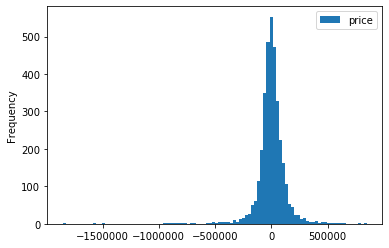

In [201]:
# Normality of the residual
residual_df = y_hat-y_test
residual_df.plot(kind='hist', bins=100);

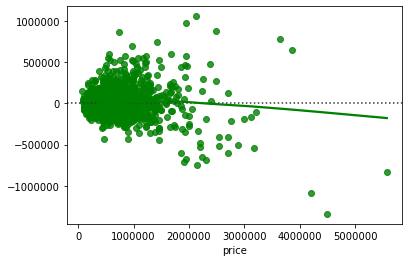

In [202]:
# homoscedacity
sns.residplot(y_test, y_hat, lowess=True, color='g');

# Feature Selection

I currently have 3x too many features in my model. It is producing consistent results but the model is too complex to interpret. I will run recursive feature selection and contrast that with Select K best to select my top 130 features to use. However, when I parse the features down, my results get significantly worse. I am happy that I checked, but I am goingto run with the features that I have

In [135]:
model = LinearRegression()
rfe = RFE(estimator=model, n_features_to_select=1, step=1)
rfe = rfe.fit(X_train, y_train)
selected_rfe_features= pd.DataFrame({'Feature': list(X_train.columns),
                                    'Ranking': rfe.ranking_})


In [175]:
top_130 =selected_rfe_features.sort_values(by='Ranking')[:130].Feature.to_list()

In [206]:
# Create a new dataframe with just the top 130 (sqrt(X)) features
top_130_features_X = poly_zip_geo[top_130]

In [207]:
# Split the data into training and test data
Xf_train, Xf_test, yf_train, yf_test = train_test_split(top_130_features_X, y,               # Pass in our X and y
                                                    random_state=42,    # Abritary select a random_state 
                                                    test_size=.2        # Split test size to be 20% of full data.
                                                   )

y_train.shape, X_train.shape

lr = LinearRegression()
lr.fit(Xf_train, (yf_train))
yf_hat =lr.predict(Xf_test)
RMSE = mean_squared_error(yf_test, (yf_hat))

RMSE**0.5

150091.34878855263

In [208]:
from sklearn.model_selection import cross_val_score
lr = LinearRegression()
(cross_val_score(estimator=lr, X=Xf_train, y=yf_train, cv = 10))

array([0.80671527, 0.79011855, 0.86914425, 0.81259313, 0.84556458,
       0.85268042, 0.82355598, 0.80900181, 0.81890034, 0.80375555])

#### Recursive Feature selection did not yeild better results

I will try Select K best using the critical f-score and p value associated with it.

## Select K best
If you have a low p value, does that mean that the f-score is beyond the critical value?

In [168]:
lr = LinearRegression()

k_best = SelectKBest(f_regression, k=20)
best = k_best.fit_transform(X_train, y_train)

In [170]:
len(best)

13832

In [163]:
# pd.DataFrame.from_dict({x:y for x,y in list(zip(X_train,k_best.pvalues_))})
dicty  = {x:y for x,y in list(zip(X_train,k_best.pvalues_))}
nulls = [x for x in dicty if not dicty[x] > 0.05]
len(nulls)

323

In [166]:
type(dicty['bedrooms'])

numpy.float64

# Lasso 

In [243]:
lasso = Lasso(alpha = 0.1, tol=0.001)
lasso.fit(X_train, y_train)

/Users/TjH/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 117862856258770.02, tolerance: 1949158364070.8918
  positive)


Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.001, warm_start=False)

In [132]:
y_hat = clf.predict(X_test)
RMSE = mean_squared_error(y_test, (y_hat))

RMSE**0.5

131796.2985644059

In [ ]:
from sklearn.model_selection import cross_val_score
lr = LinearRegression()
(cross_val_score(estimator=lr, X=X_train, y=y_train, cv = 10))

## Test interaction's between zipcode and regular features

In [67]:
df_zipcode = pd.concat([df ,train_zipcode], axis=1)
df_zipcode.shape

(17290, 87)

In [68]:
poly_2 = PolynomialFeatures(degree=2, include_bias=False)

In [73]:
zipcode_poly = poly_2.fit_transform(df_zipcode)
poly_columns = poly_2.get_feature_names(df_zipcode.columns)
# Create the new data frame
df_poly = pd.DataFrame(zipcode_poly, columns=poly_columns)
# Look at the new data frame
df_poly.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,98178^2,98178 98188,98178 98198,98178 98199,98188^2,98188 98198,98188 98199,98198^2,98198 98199,98199^2
0,4.0,2.25,9.093020,8893.0,2.0,0.0,0.0,4.0,8.0,7.635304,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.0,3.00,8.814330,6730.0,1.0,0.0,0.0,5.0,8.0,7.512071,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,2.50,9.295876,10893.0,2.0,0.0,2.0,3.0,11.0,8.234830,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,3.50,9.589325,14608.0,2.0,0.0,2.0,3.0,12.0,8.425078,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,2.50,8.589700,5376.0,2.0,0.0,0.0,3.0,9.0,7.843849,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [107]:
# 2485 columns that include repeat columns, zipcodes are mutually exclusive
df_poly_slimmed = df_poly.iloc[:,:-2485]

In [108]:
# Split the data into training and test data
X_train, X_test, y_train, y_test = train_test_split(df_poly_slimmed, y,               # Pass in our X and y
                                                    random_state=42,    # Abritary select a random_state 
                                                    test_size=.2        # Split test size to be 20% of full data.
                                                   )

y_train.shape, X_train.shape

lr = LinearRegression()
lr.fit(X_train, (y_train))
y_hat =lr.predict(X_test)
RMSE = mean_squared_error(y_test, (y_hat))

RMSE**0.5

170538.60579410306

In [109]:
from sklearn.model_selection import cross_val_score
lr = LinearRegression()
(cross_val_score(estimator=lr, X=X_train, y=y_train, cv = 10))

array([   0.52107346, -145.96382631, -138.27347536,   -4.59106584,
       -228.9973995 ,  -36.6195822 ,    0.8637862 , -338.62604294,
         -5.3554952 ,    0.84723898])

## Trying to Lasso this set!


## Polynomial Transformations

In [464]:
# Week
df = pd.read_csv('../cleanedData/X.imputed.csv', index_col=0)
week = pd.to_datetime(df.date)
X['week'] = week.dt.strftime("%W").astype(int)
X['week^2'] = X.week**2
X['week^3'] = X.week**3


##  Non Linear Transformation

In [465]:
# log cont. variables
X.sqft_living = np.log(X.sqft_living)zz
X.sqft_living = np.log(X.sqft_lot)
X.sqft_above = np.log(X.sqft_above)


In [466]:
# Year renovated and sqft_basement are currently in the dataframe. Meaning we have their interations too
X.columns.to_list()

['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15',
 'bedrooms X bathrooms',
 'bedrooms X sqft_living',
 'bedrooms X sqft_lot',
 'bedrooms X floors',
 'bedrooms X waterfront',
 'bedrooms X view',
 'bedrooms X condition',
 'bedrooms X grade',
 'bedrooms X sqft_above',
 'bedrooms X sqft_basement',
 'bedrooms X yr_built',
 'bedrooms X yr_renovated',
 'bedrooms X lat',
 'bedrooms X long',
 'bedrooms X sqft_living15',
 'bedrooms X sqft_lot15',
 'bathrooms X bedrooms',
 'bathrooms X sqft_living',
 'bathrooms X sqft_lot',
 'bathrooms X floors',
 'bathrooms X waterfront',
 'bathrooms X view',
 'bathrooms X condition',
 'bathrooms X grade',
 'bathrooms X sqft_above',
 'bathrooms X sqft_basement',
 'bathrooms X yr_built',
 'bathrooms X yr_renovated',
 'bathrooms X lat',
 'bathrooms X long',
 'bathrooms X sqft_living15',
 '

In [467]:
# Split the data into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y,               # Pass in our X and y
                                                    random_state=42,    # Abritary select a random_state 
                                                    test_size=.2        # Split test size to be 20% of full data.
                                                   )

In [468]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_hat =lr.predict(X_test)
RMSE = mean_squared_error(y_test, y_hat)
RMSE**0.5

179792.96031274536

In [469]:
from sklearn.model_selection import cross_val_score
lr = LinearRegression()
(cross_val_score(estimator=lr, X=X_train, y=y_train, cv = 10))

array([0.62643602, 0.71089107, 0.79391608, 0.71122   , 0.76530289,
       0.77280028, 0.73970805, 0.75849608, 0.73437696, 0.75194961])

## Now that we have a model with all of the interaction features, we can concatenate it with the all of our geospatial features time series features

In [470]:
# X_full_model_one has all of our geospatial and time data in it
X_full_model_one = pd.read_csv('../raw/X_full_model_one.csv', index_col=0)

In [471]:
# first 21 features are repeated in our X dataframe so we can drop them
list(enumerate(list(X_full_model_one.columns)))

[(0, 'id'),
 (1, 'date'),
 (2, 'bedrooms'),
 (3, 'bathrooms'),
 (4, 'sqft_living'),
 (5, 'sqft_lot'),
 (6, 'floors'),
 (7, 'waterfront'),
 (8, 'view'),
 (9, 'condition'),
 (10, 'grade'),
 (11, 'sqft_above'),
 (12, 'sqft_basement'),
 (13, 'yr_built'),
 (14, 'yr_renovated'),
 (15, 'zipcode'),
 (16, 'lat'),
 (17, 'long'),
 (18, 'sqft_living15'),
 (19, 'sqft_lot15'),
 (20, 'c22uz'),
 (21, 'c22vm'),
 (22, 'c22vn'),
 (23, 'c22vp'),
 (24, 'c22vr'),
 (25, 'c22vs'),
 (26, 'c22vt'),
 (27, 'c22vu'),
 (28, 'c22vv'),
 (29, 'c22vw'),
 (30, 'c22vz'),
 (31, 'c22yj'),
 (32, 'c22yp'),
 (33, 'c22yq'),
 (34, 'c22yr'),
 (35, 'c22yw'),
 (36, 'c22yx'),
 (37, 'c22yy'),
 (38, 'c22yz'),
 (39, 'c22zn'),
 (40, 'c22zp'),
 (41, 'c22zq'),
 (42, 'c22zr'),
 (43, 'c22zx'),
 (44, 'c22zy'),
 (45, 'c22zz'),
 (46, 'c23hb'),
 (47, 'c23hc'),
 (48, 'c23hf'),
 (49, 'c23hg'),
 (50, 'c23hr'),
 (51, 'c23hu'),
 (52, 'c23hv'),
 (53, 'c23hw'),
 (54, 'c23hx'),
 (55, 'c23hy'),
 (56, 'c23hz'),
 (57, 'c23j0'),
 (58, 'c23j1'),
 (59, 'c23

In [472]:
# supset to remove the first 21 columns which overlap with our X column to avoid double ups
X_full_model_one = X_full_model_one.iloc[:,21:]

In [473]:
X.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,sqft_lot15 X grade,sqft_lot15 X sqft_above,sqft_lot15 X sqft_basement,sqft_lot15 X yr_built,sqft_lot15 X yr_renovated,sqft_lot15 X lat,sqft_lot15 X long,week,week^2,week^3
0,4,2.25,9.093020,8893,2.0,0,0,4,8,7.635304,...,59290000,59290000,59290000,59290000,59290000,59290000,59290000,40,1600,64000
1,5,3.00,8.814330,6730,1.0,0,0,5,8,7.512071,...,39476089,39476089,39476089,39476089,39476089,39476089,39476089,33,1089,35937
2,4,2.50,9.295876,10893,2.0,0,2,3,11,8.234830,...,93799225,93799225,93799225,93799225,93799225,93799225,93799225,32,1024,32768
3,3,3.50,9.589325,14608,2.0,0,2,3,12,8.425078,...,202379076,202379076,202379076,202379076,202379076,202379076,202379076,13,169,2197
4,3,2.50,8.589700,5376,2.0,0,0,3,9,7.843849,...,16402500,16402500,16402500,16402500,16402500,16402500,16402500,28,784,21952


In [474]:
# Create our new X
X = pd.concat([X_full_model_one, X], axis=1)

In [475]:
# 571 features!!
X.head()

,c22vm,c22vn,c22vp,c22vr,c22vs,c22vt,c22vu,c22vv,c22vw,c22vz,...,sqft_lot15 X grade,sqft_lot15 X sqft_above,sqft_lot15 X sqft_basement,sqft_lot15 X yr_built,sqft_lot15 X yr_renovated,sqft_lot15 X lat,sqft_lot15 X long,week,week^2,week^3
0,0,0,0,0,0,0,0,0,0,0,...,59290000,59290000,59290000,59290000,59290000,59290000,59290000,40,1600,64000
1,0,0,0,0,0,0,0,0,0,0,...,39476089,39476089,39476089,39476089,39476089,39476089,39476089,33,1089,35937
2,0,0,0,0,0,0,0,0,0,0,...,93799225,93799225,93799225,93799225,93799225,93799225,93799225,32,1024,32768
3,0,0,0,0,0,0,0,0,0,0,...,202379076,202379076,202379076,202379076,202379076,202379076,202379076,13,169,2197
4,0,0,0,0,0,0,0,0,0,0,...,16402500,16402500,16402500,16402500,16402500,16402500,16402500,28,784,21952


## Model fit and Validation

In [570]:
# Split the data into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y,               # Pass in our X and y
                                                    random_state=42,    # Abritary select a random_state 
                                                    test_size=.2        # Split test size to be 20% of full data.
                                                   )

In [571]:
y_train.shape, X_train.shape

((13832, 1), (13832, 539))

In [572]:
lr = LinearRegression()
lr.fit(X_train, (y_train.price))
y_hat =lr.predict(X_test)
RMSE = mean_squared_error(y_test, (y_hat))

In [573]:
RMSE**0.5

134677.95472549615

In [536]:
coefficient = list(zip(X_train, lr.coef_))
coefficient

[('c22vm', -102441.8160951722),
 ('c22vn', -19981.665862649534),
 ('c22vp', 37696.923485262254),
 ('c22vr', 18961.97464521038),
 ('c22vs', 42449.704602854705),
 ('c22vt', -4969.229812918973),
 ('c22vu', -62383.82059294357),
 ('c22vv', 99603.81325545431),
 ('c22vw', -52663.45054678754),
 ('c22vz', 98793.84603021941),
 ('c22yj', -23738.054842680507),
 ('c22yp', 67433.93460184903),
 ('c22yq', 144349.51120958212),
 ('c22yr', 119149.35330530819),
 ('c22yw', 154289.4539866643),
 ('c22yx', 144967.28462303794),
 ('c22yy', 324804.2897617924),
 ('c22yz', 342512.00211421755),
 ('c22zn', 216238.38837508208),
 ('c22zp', 152746.14908086797),
 ('c22zq', 109607.58095443783),
 ('c22zr', 102031.76901975593),
 ('c22zx', 51401.69627712714),
 ('c22zy', -26813.812329865166),
 ('c22zz', 19834.063157390854),
 ('c23hb', 14275.795405578645),
 ('c23hc', -10718.592466143746),
 ('c23hf', 3647.623092427057),
 ('c23hg', -13011.896807205325),
 ('c23hr', -22345.581415271234),
 ('c23hu', 29306.55236642151),
 ('c23hv', 

(array([2.000e+00, 5.000e+00, 6.000e+00, 1.600e+01, 1.060e+02, 2.511e+03,
        7.630e+02, 4.000e+01, 6.000e+00, 3.000e+00]),
 array([-1413968.41806629, -1167970.99319261,  -921973.56831892,
         -675976.14344524,  -429978.71857155,  -183981.29369786,
           62016.13117582,   308013.55604951,   554010.98092319,
          800008.40579688,  1046005.83067057]),
 <a list of 10 Patch objects>)

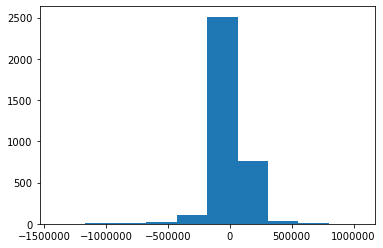

In [537]:
import matplotlib.pyplot as plt
plt.hist(y_hat  - y_test.price)

/Users/TjH/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


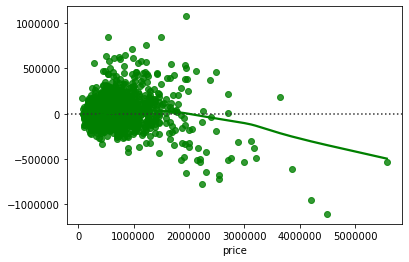

In [531]:
sns.residplot(y_test.price, y_hat, lowess=True, color='g')

In [507]:
from scipy.stats import sem

In [360]:
from sklearn.model_selection import cross_val_score
lr = LinearRegression()
cross_val = (cross_val_score(estimator=lr, X=X, y=y, cv = 10))
cross_val_mean = round(np.mean(cross_val),2)
cross_val_std = round(np.std(cross_val),2)

standard_error = round(sem(cross_val), 2)

print(f"The RMSE of the current model is {RMSE} with a mean 10 fold cross validation score (R^2) of {cross_val_mean}, with a standard deviation of {cross_val_std} \
with a standard error of {standard_error}")

The RMSE of the current model is 134677.95 with a mean 10 fold cross validation score (R^2) of 0.84, with a standard deviation of 0.02 with a standard error of 0.01


## This is a very strong model! 

#### But we have a lot of features. We should widdle them down using RSE. 


### Feature Selection

In [362]:
model = LinearRegression()
rfe = RFE(estimator=model, n_features_to_select=100, step=1)
rfe = rfe.fit(X_train, y_train)
selected_rfe_features= pd.DataFrame({'Feature': list(X_train.columns),
                                    'Ranking': rfe.ranking_})
selected_rfe_features.sort_values(by='Ranking')[:100]

/Users/TjH/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Feature,Ranking
94,c23nd,1
235,98144,1
120,c23p6,1
118,c23p4,1
117,c23p3,1
...,...,...
1,c22vn,1
6,c22vu,1
7,c22vv,1
485,lat X yr_renovated,1


In [399]:
X_top_100 = X[selected_rfe_features.sort_values(by='Ranking').Feature.to_list()]

In [400]:
# Split the data into training and test data
X_train, X_test, y_train, y_test = train_test_split(X_top_100, y,               # Pass in our X and y
                                                    random_state=42,    # Abritary select a random_state 
                                                    test_size=.2        # Split test size to be 20% of full data.
                                                   )

In [401]:
lr = LinearRegression()
lr.fit(X_train, y_train.price)
y_hat =lr.predict(X_test)
RMSE = mean_squared_error(y_test, y_hat)
RMSE**0.5

134748.08200853696

In [290]:
df = pd.read_csv('../raw/kc_holdout_data.csv', index_col=0)

to_drop = [
    'date', # handled as dummy columns/seasons
    'id', # randomly generated
    'zipcode', # handled as dummy columns
]
df.drop(columns=to_drop, inplace = True)

In [291]:
df.yr_built = df.yr_built.apply(lambda x: 2015-x)
df.yr_renovated = df.yr_renovated.apply(lambda x: 2015-x)

In [292]:
# impute the median beds and bad


In [300]:
df.sort_values('sqft_living', ascending = False)

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
1012,5,6.25,8020,21738,2.0,0,0,3,11,8020,0,14,2015,47.5675,-122.189,4160,18969
2568,4,4.00,7850,89651,2.0,0,0,3,12,7850,0,9,2015,47.5406,-121.982,6210,95832
1187,8,4.00,7710,11750,3.5,0,0,5,12,6090,1620,111,2015,47.6263,-122.314,4210,8325
1304,5,4.00,7320,217800,2.0,0,0,3,11,7320,0,23,2015,47.4473,-122.086,3270,34500
4216,5,6.50,7270,130017,2.0,0,0,3,12,6420,850,5,2015,47.5371,-121.982,1800,44890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,1,0.75,480,9750,1.0,0,0,2,4,480,0,67,2015,47.4982,-122.362,1550,9924
762,1,1.00,460,4120,1.0,0,0,3,4,460,0,78,2015,47.4868,-122.199,990,4120
4042,1,1.00,390,2000,1.0,0,0,4,6,390,0,95,2015,47.6938,-122.347,1340,5100
1089,0,0.75,384,213444,1.0,0,0,3,4,384,0,12,2015,47.4177,-122.491,1920,224341


In [299]:
df.sqft_living.describe()

count    4323.000000
mean     2183.344899
std       966.768796
min       290.000000
25%      1452.000000
50%      2000.000000
75%      2730.000000
max      8020.000000
Name: sqft_living, dtype: float64

In [ ]:
holdout = pd.read_csv('../raw/kc_holdout_data.csv', index_col=0)

# create interaction dataframe

# drop columns we are not interested in
holdout.drop(columns=to_drop, inplace=True)

# Run the holdout dataframe through my function

holdout_interactions = get_interactions(holdout)

holdout_interactions.shape

# # test the model at scale
# holdout = pd.read_csv('../raw/kc_holdout_data.csv')
# # Get zipcode dummies 
# zipcodes_dummies = pd.get_dummies(holdout.zipcode)

to_drop = [
    'date', # handled as dummy columns/seasons
    'id', # randomly generated
    'zipcode', # handled as dummy columns
    'yr_renovated',

]
# get geo

### So the best we can do is 150K range, that has no feature normalization at all. How do we improve this?

holdoutZipcodes = pd.read_csv('../cleanedData/holdoutZipcodes.csv', index_col=0)
holdoutGeo = pd.read_csv('../cleanedData/holdoutGeo.csv', index_col=0)
holdoutSeason = pd.read_csv('../cleanedData/holdoutSeason.csv', index_col=0)
X_holdout = pd.read_csv('../raw/kc_holdout_data.csv', index_col=0)



holdout_df = pd.concat([X_holdout, holdoutGeo,holdoutZipcodes, holdoutSeason], axis=1)
holdout_df = holdout_df.drop(columns=to_drop)

hold_out_full = pd.concat([holdout_df,holdout_interactions], axis=1)

# Split the data into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y,               # Pass in our X and y
                                                    random_state=42,    # Abritary select a random_state 
                                                    test_size=.2        # Split test size to be 20% of full data.
                                                   )

X_train

lr = LinearRegression()
lr.fit(X, y)
y_hat =lr.predict(hold_out_full)
# RMSE = mean_squared_error(y, y_hat)

pd.DataFrame(y_hat).to_csv('../cleanedData/modeltwo.csv')

from sklearn.model_selection import cross_val_score
lr = LinearRegression()
(cross_val_score(estimator=lr, X=X_train, y=y_train, cv = 10))

pd.read_csv('../cleanedData/modeltwo.csv')